In [2]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

In [55]:
import pyref as rf
from pypxr.structure import PXR_Structure, PXR_SLD, PXR_MaterialSLD
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *

# Experimental Configuration

In this notebook, we play arround with the idea that that the experiment could change in configuration between collecting s and p polarizaed data. Thus we will fit seperately s and p pol data and compare the results. 

<Axes: xlabel='Q'>

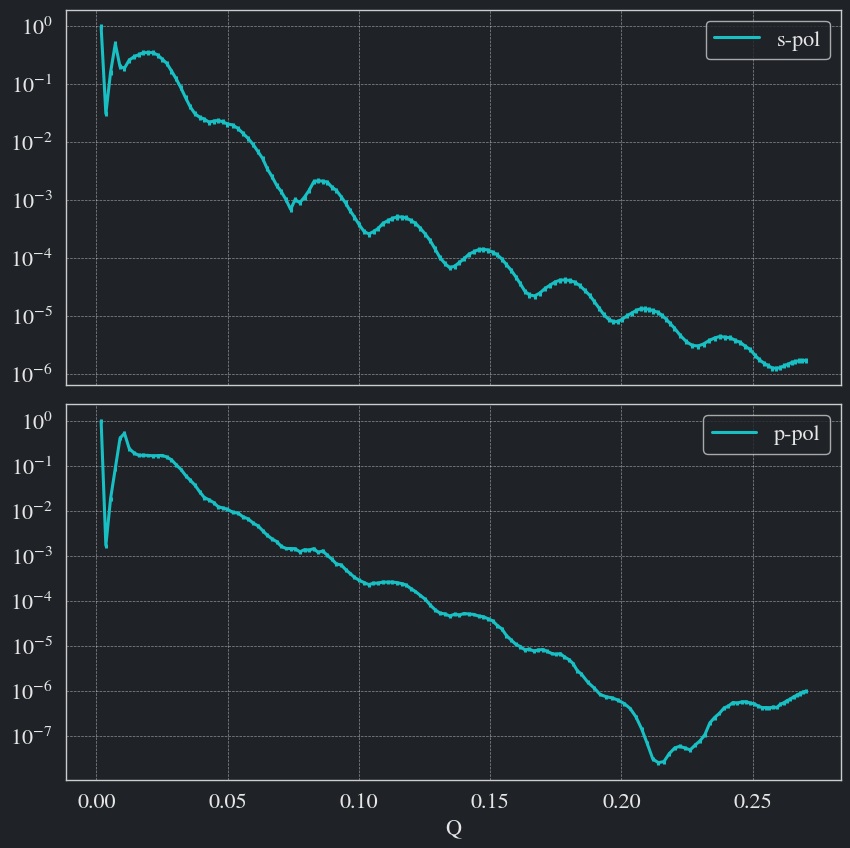

In [4]:
import matplotlib.pyplot as plt
db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")

#------------------------------------------------
# Load data
# Data loading is focused on the 283.7 ev data set
#------------------------------------------------

s_pol = db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc")
p_pol = db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc")

#------------------------------------------------
# Plot data
#------------------------------------------------

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={"hspace": 0.05})
s_pol.plot(ax=ax[0], label="s-pol", x = "Q", y = "Refl", yerr = "Err", logy=True)
p_pol.plot(ax=ax[1], label="p-pol", x = "Q", y = "Refl", yerr = "Err", logy=True)

In [96]:
#------------------------------------------------
# Load Structure Parameters
#------------------------------------------------

struct = db.get_struct("ZnPc_RoomTemp")
struct

{'comments': ['Layers must be in the order from top to bottom, as they wil be stacked into a structure like Vacuum | C|SiO2|Si ',
  'Vacuum layer must have thickness and roughness of 0, and density of 0',
  'Density is in g/cm^3, thickness in A, roughness in A',
  'Si layer must have density of 0, thickness of 0, but the roughness can be anything'],
 'layers': ['Vacuum', 'C32H16N8Zn', 'C', 'SiO2', 'Si'],
 'Vacuum': {'density': 0, 'roughness': 0, 'thickness': 0},
 'C32H16N8Zn': {'thickness': 196.441, 'roughness': 7.21628, 'density': 1.6},
 'C': {'thickness': 6.08467, 'roughness': 4.40733, 'density': 1.62331},
 'SiO2': {'thickness': 8.000003, 'roughness': 6.38308, 'density': 1.62331},
 'Si': {'density': 0, 'roughness': 1.5, 'thickness': 0}}

# P-pol Model

The p-pol data will show anisotropy in the media and thus we will use it to fit the tensor components

In [97]:
from dataclasses import dataclass
from typing import Literal
en = 283.7
ns = znpc_oc(en, density = struct["C32H16N8Zn"]["density"])

# TODO: Make this work

#------------------------------------------------
# Data Structures
#------------------------------------------------

# type Energy = float | int | list[float] | list[int]
# type MolecularName = str
# type _SLD = rf.OrientedOpticalConstants | rf.OpticalConstant
# type SldParam = Literal["delta", "beta","xx", "ixx", "zz", "izz", "rho"]
# type SlabParam = Literal["thick", "rough"]

# @dataclass
# class Param:
#     name: SldParam | SlabParam
#     value: float | int
#     vary: bool
#     bounds: tuple | None = None

# @dataclass
# class SLD:
#     name: MolecularName
#     energy: Energy
#     rho: Param
#     kind: Literal["oc", "material"]
#     sld: list[_SLD] | _SLD | None = None
#     vary: bool = True

#     def make_sld(self):
#         if self.kind == "ooc":
#             oc = znpc_oc(self.energy, density = self.rho.value)
#             sld = PXR_SLD(oc, znpc_oc.symmetry, name = self.name)
#         elif self.kind == "material":
#             if self.name == "Vacuum":
#                 name = ""
#             else:
#                 name = self.name
#             sld = PXR_MaterialSLD(name, self.rho.value, self.energy, name = self.name)
#             self.vary = False
#         return sld

#     def __post_init__(self):
#         self.sld = self.make_sld()

#     def __len__(self):
#         if isinstance(self.sld, list):
#             return len(self.sld)
#         else:
#             return 1

#     def __getitem__(self, index):
#         if isinstance(self.sld, list):
#             return self.sld[index]
#         else:
#             return self.sld


# @dataclass
# class Slab:
#     thick: Param
#     sld: SLD
#     rough: Param
#     name: MolecularName
#     energy: Energy | None = None

#     def bind(self, structure: PXR_Structure, index):
#         if index == len(self.sld):
#             return

#         slab = self.sld[index](self.thick.value, self.rough.value)
#         slab.thick.setp(vary=self.thick.vary, bounds=self.thick.bounds)
#         slab.rough.setp(vary=self.rough.vary, bounds=self.rough.bounds)
#         structure |= slab
#         index += 1
#         self.bind(structure, index)

#     def __post_init__(self):
#         self.energy = self.sld.energy



# @dataclass
# class Structure:
#     slabs: list[Slab]
#     struct: PXR_Structure|None = None
#     #------------------------------------------------

#     def process_slab(self, index):
#         if index == len(self.slabs):
#             return

#         self.slabs[index].bind(self.struct, 0)
#         index += 1
#         self.process_slab(index)

#     def __post_init__(self):
#         self.struct = PXR_Structure()
#         self.process_slab(0)

In [99]:
slabs = []
for layer in struct["layers"]:
    thick = Param("thick", struct[layer]["thickness"], True)
    rough = Param("rough", struct[layer]["roughness"], True)
    rho = Param("rho", struct[layer]["density"], True)
    if layer == "C32H16N8Zn":
        sld = SLD(layer, en, rho, kind = "ooc")
    else:
        sld = SLD(layer, en, rho, kind = "material")
    slab = Slab(thick, sld, rough, layer)
    slabs.append(slab)

structure = Structure(slabs)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='z / $\\AA$', ylabel='Index of refraction'>)

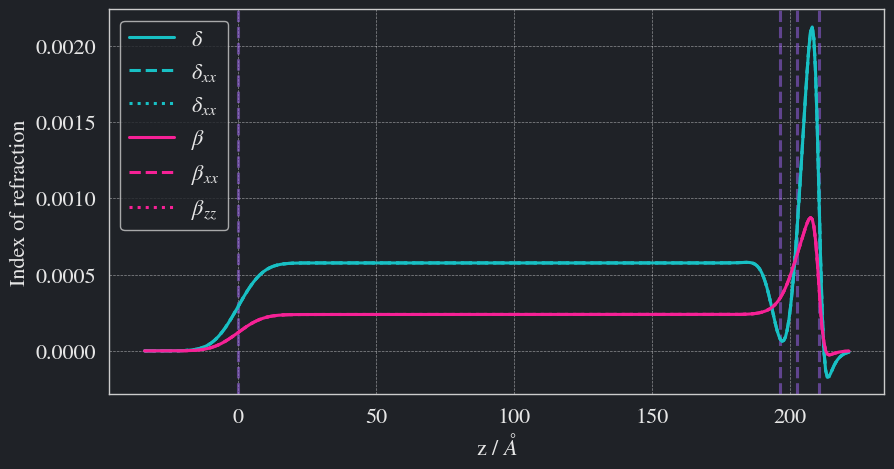

In [94]:
structure.struct.plot()